# Q6-Multi-Layer Perceptron (MLP)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from matplotlib.lines import Line2D
from sklearn.metrics import accuracy_score

path=r"C:\Unipi-CS\5ο εξάμηνο\Αναγνώριση Προτύπων\project\Data\original dataset\crimes.csv"

data=pd.read_csv(path)

In [2]:
train_df=data[data["split"]=="TRAIN"]
val_df=data[data["split"]=="VAL"]


x_train=train_df.drop(columns=["killer_id"])
y_train=train_df["killer_id"]

x_val=val_df.drop(columns=["killer_id"])
y_val=val_df["killer_id"]

In [3]:
categorical_features = ["weapon_code", "scene_type", "weather", "vic_gender"]
continuous_features = ["hour_float", "latitude", "longitude", "victim_age", "temp_c", "humidity", "dist_precinct_km", "pop_density"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

mlp_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(64, 32), 
    activation='relu', 
    solver='adam', 
    alpha=0.001, 
    batch_size=32,
    learning_rate_init=0.001,
    max_iter=500, 
    early_stopping=True, 
    validation_fraction=0.1,
    random_state=42))
])
mlp_clf.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['hour_float', 'latitude',
                                                   'longitude', 'victim_age',
                                                   'temp_c', 'humidity',
                                                   'dist_precinct_km',
                                                   'pop_density']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weapon_code', 'scene_type',
                                                   'weather',
                                                   'vic_gender'])])),
                ('classifier',
                 MLPClassifier(alpha=0.001, batch_size=32, early_stopping=True,
                               hidden_layer_sizes=(64, 32), max_iter=500,
                               random_state=42))])

In [4]:
y_val_pred_mlp = mlp_clf.predict(x_val)
acc_val_mlp = accuracy_score(y_val, y_val_pred_mlp)

print(acc_val_mlp)

0.9311064718162839


<Figure size 1000x800 with 0 Axes>

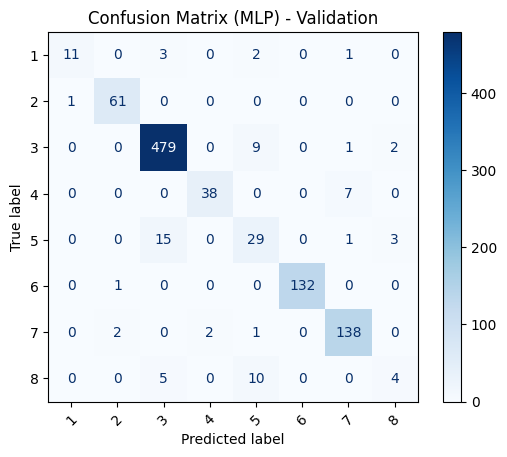

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_pred_mlp, labels=mlp_clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_clf.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", values_format="d", xticks_rotation=45)
plt.title("Confusion Matrix (MLP) - Validation")
plt.show()

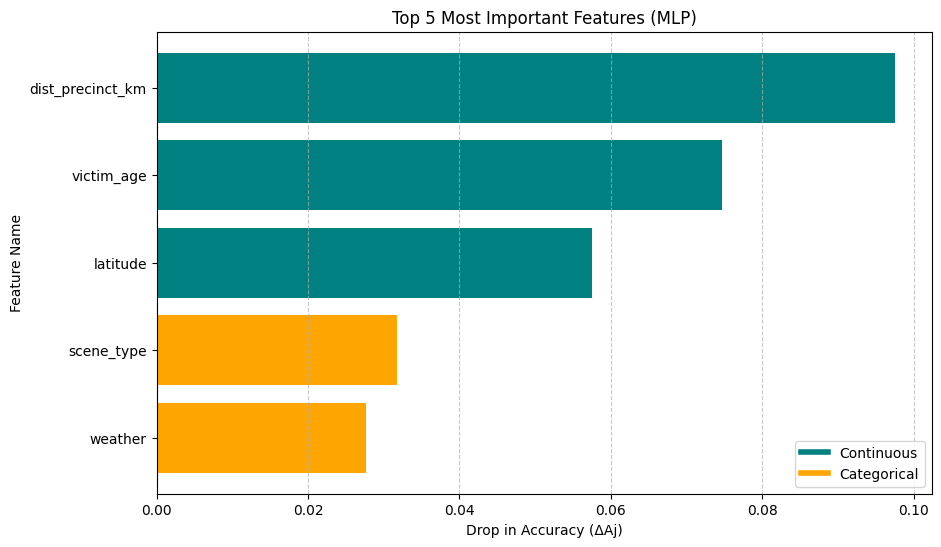

Feature: dist_precinct_km | Type: Continuous   | Importance: 0.0975
Feature: victim_age      | Type: Continuous   | Importance: 0.0747
Feature: latitude        | Type: Continuous   | Importance: 0.0575
Feature: scene_type      | Type: Categorical  | Importance: 0.0317
Feature: weather         | Type: Categorical  | Importance: 0.0277


In [6]:
input_cols = x_val.columns.tolist()

result = permutation_importance(
    mlp_clf, 
    x_val, 
    y_val, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()[::-1]
top_5_idx = sorted_idx[:5]

top_5_names = [input_cols[i] for i in top_5_idx]
top_5_values = result.importances_mean[top_5_idx]

plt.figure(figsize=(10, 6))
colors = ['teal' if name in continuous_features else 'orange' for name in top_5_names]

plt.barh(top_5_names, top_5_values, color=colors)
plt.xlabel("Drop in Accuracy (ΔAj)")
plt.ylabel("Feature Name")
plt.title("Top 5 Most Important Features (MLP)")


legend_elements = [Line2D([0], [0], color='teal', lw=4, label='Continuous'),
                   Line2D([0], [0], color='orange', lw=4, label='Categorical')]
plt.legend(handles=legend_elements)

plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

for name, val in zip(top_5_names, top_5_values):
    type_f = "Continuous" if name in continuous_features else "Categorical"
    print(f"Feature: {name:15} | Type: {type_f:12} | Importance: {val:.4f}")